## **Traffic Optimization Using a Variational Quantum Eigensolver**
by Carla Silva (October 2019) exploring the IBM Q Experience Qiskit Aqua: Experimenting with Max-Cut problem with variational quantum eigensolver 

In [2]:
!pip install qiskit

     |████████████████████████████████| 1.6MB 4.9MB/s 
     |████████████████████████████████| 21.6MB 1.0MB/s 
     |████████████████████████████████| 61kB 22.9MB/s 
     |████████████████████████████████| 102kB 29.4MB/s 
     |████████████████████████████████| 983kB 47.5MB/s 
     |████████████████████████████████| 51kB 20.1MB/s 
     |████████████████████████████████| 5.3MB 28.7MB/s 
     |████████████████████████████████| 51kB 25.2MB/s 
     |████████████████████████████████| 71kB 26.9MB/s 
     |████████████████████████████████| 21.7MB 29.0MB/s 
     |████████████████████████████████| 532kB 38.7MB/s 
     |████████████████████████████████| 2.3MB 32.9MB/s 
     |████████████████████████████████| 61kB 25.7MB/s 
     |████████████████████████████████| 61kB 26.6MB/s 
     |████████████████████████████████| 112kB 48.3MB/s 
  Created wheel for qiskit: filename=qiskit-0.12.1-cp36-none-any.whl size=1394 sha256=c00dca169782cfb2cc4db7cc6c8a0a80563a24f181b257e0604bf9d56fa94ce2
  Stored in dir

In [0]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

## (a) generating an artificial network simulating a small network in a city with random traffic flow weights

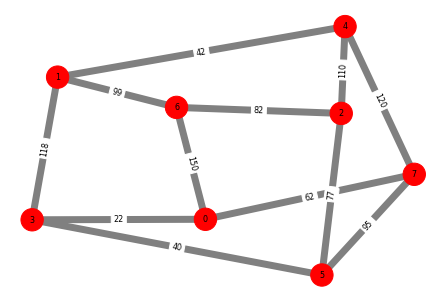

In [20]:
# Generating a graph 
from networkx import random_regular_graph
import random
G = random_regular_graph(3,8)
for (u,v,w) in G.edges(data=True):
    w['weight'] = random.randint(0,150)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, node_color = colors, edge_color = 'gray' , width = 7, node_size=500, font_size = 8, font_color='black')  #with_labels=true is to show the node number in the output graph
edge_labels = dict([((u, v,), d['weight']) for u, v, d in G.edges(data = True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, label_pos = 0.5, font_size = 8) #prints weight on all the edges
plt.show()


In [21]:
# Normalization
norm = []
for u,v,d in G.edges(data=True):
	norm.append(d['weight'])

norm = np.array(norm)
norm = (norm - norm.min()) / (norm.max() - norm.min())
for u,v,d in G.edges(data=True):
  d['weight'] = round(norm[u],2)

# Computing the weight matrix from the random graph
n = len(G)
w = np.zeros([n,n])
for u,v,d in G.edges(data=True):
  temp = G.get_edge_data(u,v,default=0)
  if temp != 0:
    w[u,v] = d['weight'] 
print(w)

[[0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.16 0.   0.   0.16 0.  ]
 [0.   0.   0.   0.   0.   0.69 0.69 0.  ]
 [0.57 0.   0.   0.   0.   0.57 0.   0.  ]
 [0.   0.31 0.31 0.   0.   0.   0.   0.31]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.6  0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


energy: -0.8781054687500001
time: 182.13315081596375
max-cut objective: -1.77310546875
solution: [0 0 0 1 1 1 1 0]
solution objective: 1.7


{(1, 3): Text(-0.2075302877601027, -0.03453415548510225, '0.16'),
 (1, 6): Text(-0.1690365606782866, 0.1544210569054001, '0.16'),
 (2, 5): Text(-0.011762786998709224, -0.3242766305600835, '0.69'),
 (2, 6): Text(-0.1474394547960273, -0.06094431687121758, '0.69'),
 (3, 0): Text(-0.5726465620367674, -0.2552933428916932, '0.57'),
 (3, 5): Text(-0.2532763844055644, -0.43637597050449306, '0.57'),
 (4, 1): Text(0.25963901159601016, 0.2915531305121304, '0.31'),
 (4, 2): Text(0.28123611747826943, 0.07618775673551276, '0.31'),
 (4, 7): Text(0.7534459097137636, 0.42514891654637676, '0.31'),
 (6, 0): Text(-0.5341528349549514, -0.06633813050119089, '0.6'),
 (7, 0): Text(0.14107682760558182, 0.20576715686358032, '0.0'),
 (7, 5): Text(0.4604470052367849, 0.024684529250780463, '0.0')}

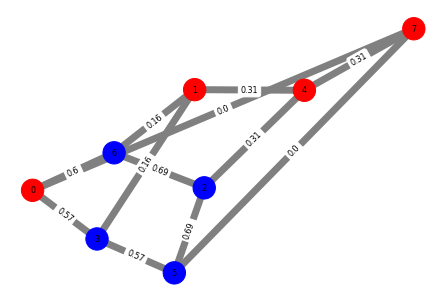

In [23]:
# Mapping to the Ising problem
qubitOp, offset = max_cut.get_max_cut_qubitops(w)
algo_input = EnergyInput(qubitOp)

# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""declarative approach, update the param from the previous cell.
params['backend']['provider'] = 'qiskit.BasicAer'
params['backend']['name'] = 'qasm_simulator'
params['backend']['shots'] = 1024
result = run_algorithm(params, algo_input)
"""

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, node_color = colors, edge_color = 'gray' ,width = 7, node_size=500, font_size = 8, font_color='black')  
edge_labels = dict([((u, v,), d['weight']) for u, v, d in G.edges(data = True)])
nx.draw_networkx_edge_labels(G, pos, with_labels = False, edge_labels = edge_labels, label_pos = 0.5, font_size = 8) 


In [24]:
!pip install osmnx


     |████████████████████████████████| 71kB 4.6MB/s 
     |████████████████████████████████| 921kB 11.7MB/s 
     |████████████████████████████████| 11.9MB 33.4MB/s 
     |████████████████████████████████| 10.1MB 27.9MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=64968222f3149ad8fa5a9838cab5e1960cda3da68c34bfcf840c26f019af7a08
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
!apt-get install -qq curl g++ make

In [26]:
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0  3124k      0 --:--:-- --:--:-- --:--:-- 3124k


In [0]:
import os
os.chdir('spatialindex-src-1.8.5')

In [28]:
!./configure

checking build system type... x86_64-unknown-linux-gnu
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking how to run the C++ preprocessor... g++ -E
checking for a BSD-compatible install... /usr/bin/install -c
checking whether ln -s works... yes
checking whether make sets $(MAKE)... yes
checking host system type... x86_64-unknown-linux-gnu
checking how to print strings... printf
checking for gcc... gcc
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking whether gcc understands -c and -o together... yes
checking for a sed that does not truncate output... /bin/sed
checking fo

In [29]:
!make

Making all in src
make[1]: Entering directory '/content/spatialindex-src-1.8.5/src'
Making all in storagemanager
make[2]: Entering directory '/content/spatialindex-src-1.8.5/src/storagemanager'
depbase=`echo Buffer.lo | sed 's|[^/]*$|.deps/&|;s|\.lo$||'`;\
/bin/bash ../../libtool  --tag=CXX   --mode=compile g++ -DPACKAGE_NAME=\"spatialindex\" -DPACKAGE_TARNAME=\"spatialindex-src\" -DPACKAGE_VERSION=\"1.8.5\" -DPACKAGE_STRING=\"spatialindex\ 1.8.5\" -DPACKAGE_BUGREPORT=\"mhadji@gmail.com\" -DPACKAGE_URL=\"\" -DSTDC_HEADERS=1 -DHAVE_SYS_TYPES_H=1 -DHAVE_SYS_STAT_H=1 -DHAVE_STDLIB_H=1 -DHAVE_STRING_H=1 -DHAVE_MEMORY_H=1 -DHAVE_STRINGS_H=1 -DHAVE_INTTYPES_H=1 -DHAVE_STDINT_H=1 -DHAVE_UNISTD_H=1 -DHAVE_DLFCN_H=1 -DLT_OBJDIR=\".libs/\" -DPACKAGE=\"spatialindex-src\" -DVERSION=\"1.8.5\" -DHAVE_FCNTL_H=1 -DHAVE_UNISTD_H=1 -DHAVE_SYS_TYPES_H=1 -DHAVE_SYS_STAT_H=1 -DHAVE_PTHREAD_H=1 -DHAVE_SYS_RESOURCE_H=1 -DHAVE_SYS_TIME_H=1 -DHAVE_STDINT_H=1 -DHAVE_FEATURES_H=1 -DHAVE_GETTIMEOFDAY=1 -DHAVE_MEM

In [30]:
!make install

Making install in src
make[1]: Entering directory '/content/spatialindex-src-1.8.5/src'
Making install in storagemanager
make[2]: Entering directory '/content/spatialindex-src-1.8.5/src/storagemanager'
make[3]: Entering directory '/content/spatialindex-src-1.8.5/src/storagemanager'
make[3]: Nothing to be done for 'install-exec-am'.
make[3]: Nothing to be done for 'install-data-am'.
make[3]: Leaving directory '/content/spatialindex-src-1.8.5/src/storagemanager'
make[2]: Leaving directory '/content/spatialindex-src-1.8.5/src/storagemanager'
Making install in spatialindex
make[2]: Entering directory '/content/spatialindex-src-1.8.5/src/spatialindex'
make[3]: Entering directory '/content/spatialindex-src-1.8.5/src/spatialindex'
make[3]: Nothing to be done for 'install-exec-am'.
make[3]: Nothing to be done for 'install-data-am'.
make[3]: Leaving directory '/content/spatialindex-src-1.8.5/src/spatialindex'
make[2]: Leaving directory '/content/spatialindex-src-1.8.5/src/spatialindex'
Making i

In [31]:
!pip install rtree

In [0]:
!ldconfig

In [33]:
!sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
python-dev is already the newest version (2.7.15~rc1-1).
graphviz is already the newest version (2.40.1-2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 8 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archi

In [34]:
!pip install pygraphviz

     |████████████████████████████████| 122kB 4.9MB/s 
  Created wheel for pygraphviz: filename=pygraphviz-1.5-cp36-cp36m-linux_x86_64.whl size=157587 sha256=044f7e88739c3a46e8172d79c52c61f8b378f850bb2d4c4658f90692c2f81a0f
  Stored in directory: /root/.cache/pip/wheels/65/54/69/1aee9e66ab19916293208d4c9de0d3898adebe6b2eeff6476b
Successfully built pygraphviz


## (b) generating a real-world city network considering the length of the road links as the weights

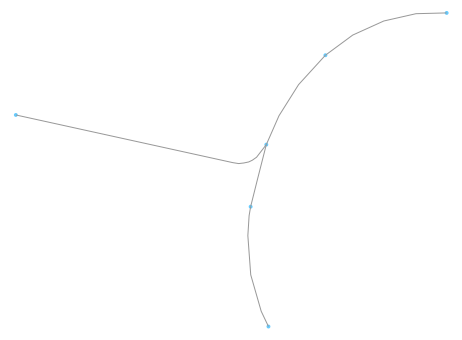

In [35]:
import osmnx as ox
# Boavista, Porto, Portugal
location_point = (41.158132, -8.629149) 
G = ox.graph_from_point(location_point, distance=300, distance_type='network', network_type='drive')
ox.plot_graph(G)
G = nx.convert_node_labels_to_integers(G)

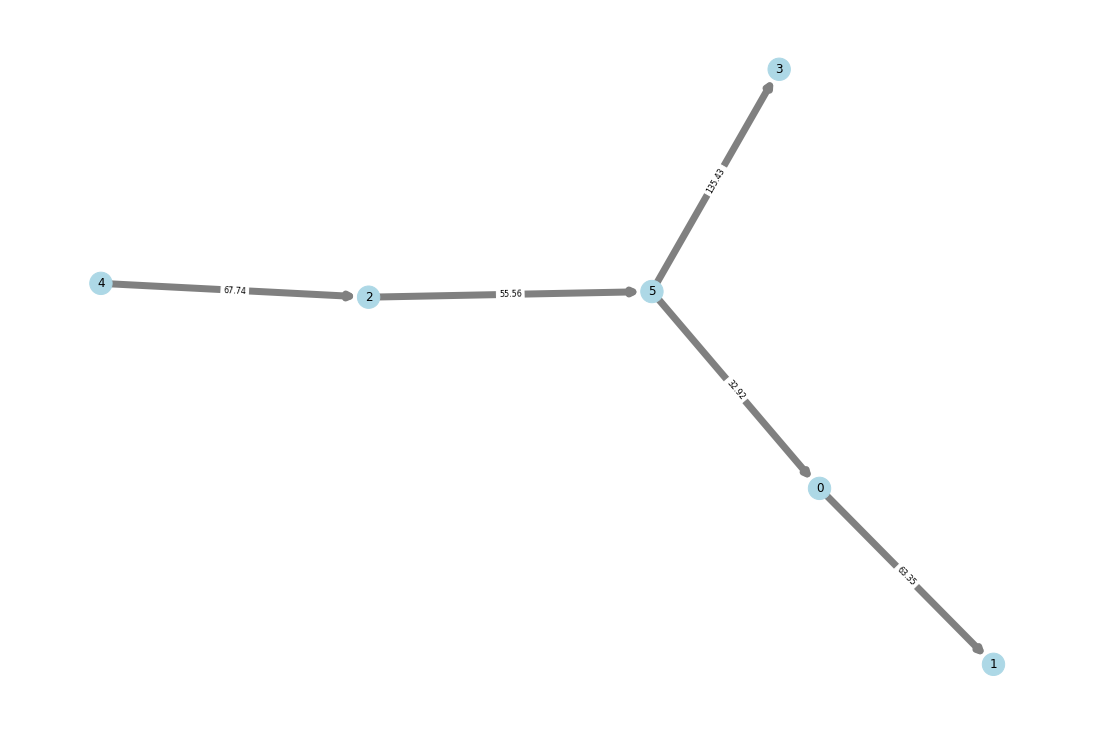

In [36]:
# Round decimal places
for u,v,d in G.edges(data=True):
	d['length'] = round(d['length'],2)

plt.figure(figsize=(15,10))
colors = ['lightblue' for node in G.nodes()]
pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
nx.draw(G, pos, with_labels = True, node_color = colors, edge_color = 'gray' , node_size=500, width = 7)  
edge_labels = dict([((u, v,), d['length']) for u, v, d in G.edges(data = True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, label_pos = 0.5, font_size = 8) 
plt.show()

In [37]:
# Normalization
norm = []
for u,v,d in G.edges(data=True):
	norm.append(d['length'])

norm = np.array(norm)
norm = (norm - norm.min()) / (norm.max() - norm.min())

i = 0
for u,v,d in G.edges(data=True):
  d['length'] = round(norm[i],2)
  i = i + 1

# Computing the weight matrix from the random graph
n = len(G)
w = np.zeros([n,n])
for u,v,d in G.edges(data=True):
  temp = G.get_edge_data(u,v,default=0)
  if temp != 0:
    w[u,v] = d['length'] 
print(w)

[[0.   0.3  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.22]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.34 0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.  ]]


In [0]:
# Mapping to the Ising problem
qubitOp, offset = max_cut.get_max_cut_qubitops(w)
algo_input = EnergyInput(qubitOp)

energy: -0.668359375
time: 128.50896167755127
max-cut objective: -1.338359375
solution: [1 1 0 0 1 1]
solution objective: 0.22


{(0, 1): Text(0.10353256033820407, -0.8077257745040187, '0.3'),
 (2, 5): Text(0.040341355847411386, 0.22012942624481613, '0.22'),
 (4, 2): Text(-0.07164709351739162, 0.29535082186792205, '0.34'),
 (5, 0): Text(-0.0007133099869795004, -0.2438248581505389, '0.0'),
 (5, 3): Text(-0.0318854668208123, 0.5123749526360968, '1.0')}

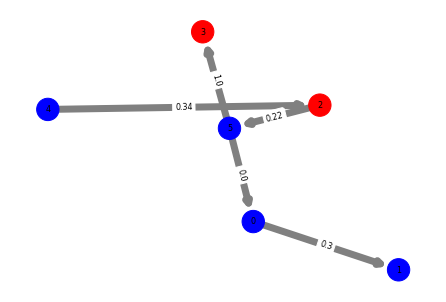

In [39]:
# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""declarative approach, update the param from the previous cell.
params['backend']['provider'] = 'qiskit.BasicAer'
params['backend']['name'] = 'qasm_simulator'
params['backend']['shots'] = 1024
result = run_algorithm(params, algo_input)
"""

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, node_color = colors, edge_color = 'gray' ,width = 7, node_size=500, font_size = 8, font_color='black')  
edge_labels = dict([((u, v,), d['length']) for u, v, d in G.edges(data = True)])
nx.draw_networkx_edge_labels(G, pos, with_labels = False, edge_labels = edge_labels, label_pos = 0.5, font_size = 8) 


In [40]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright